In [97]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ccxt
import ta
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tf.compat.v1.enable_eager_execution()

In [98]:
def fetch_ohlcv(symbol, exchange_id, timeframe, since=None, limit=1000, max_bars=None):
    exchange = getattr(ccxt, exchange_id)()
    exchange.load_markets()

    all_bars = []
    fetch_since = since if since else exchange.milliseconds() - (max_bars * 60 * 60 * 1000)  # Adjusted for 1-hour data

    while len(all_bars) < max_bars:
        try:
            new_bars = exchange.fetch_ohlcv(symbol, timeframe, since=fetch_since, limit=limit)

            if not new_bars:
                print("No new bars returned. Stopping...")
                break  # Stop if no new data is returned

            all_bars.extend(new_bars)  # Append new data
            print(f"Fetched {len(new_bars)} bars, Total: {len(all_bars)}")

            fetch_since = new_bars[-1][0] + 1  # Move `since` forward

            if len(new_bars) < limit:
                print("Last batch returned less than the limit. Likely at the end of data.")
                break  # Stop if no more data is available
            
            time.sleep(exchange.rateLimit / 1000)  # Avoid API rate limits
            
        except Exception as e:
            print(f"Error fetching data: {e}")
            break
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # **Updated Technical Indicators for 1-Hour Data**
    df["SMA_20"] = ta.trend.sma_indicator(df["close"], window=20)  # 20-period SMA
    df["SMA_50"] = ta.trend.sma_indicator(df["close"], window=50)  # 50-period SMA
    df["EMA_20"] = ta.trend.ema_indicator(df["close"], window=20)  # 20-period EMA
    df["RSI_14"] = ta.momentum.rsi(df["close"], window=14)  # RSI (Relative Strength Index)
    df["MACD"] = ta.trend.macd(df["close"])  # MACD Line
    df["MACD_Signal"] = ta.trend.macd_signal(df["close"])  # MACD Signal Line
    df["ATR_14"] = ta.volatility.average_true_range(df["high"], df["low"], df["close"], window=14)  # ATR
    
    df.dropna(inplace=True)  # Drop NaN values from indicator calculations
    
    print(f"Final data count: {len(df)} bars")
    return df

In [99]:
feature_columns = ['open', 'high', 'low', 'volume', "SMA_20", "SMA_50", "EMA_20", "RSI_14", "MACD", "MACD_Signal", "ATR_14"]
target_column = ['close']

In [100]:
fetch = fetch_ohlcv("BTC/USDT", "binance", "1h", max_bars = 10000 + 49)

Fetched 1000 bars, Total: 1000
Fetched 1000 bars, Total: 2000
Fetched 1000 bars, Total: 3000
Fetched 1000 bars, Total: 4000
Fetched 1000 bars, Total: 5000
Fetched 1000 bars, Total: 6000
Fetched 1000 bars, Total: 7000
Fetched 1000 bars, Total: 8000
Fetched 1000 bars, Total: 9000
Fetched 1000 bars, Total: 10000
Fetched 49 bars, Total: 10049
Last batch returned less than the limit. Likely at the end of data.
Final data count: 10000 bars


In [101]:
fetch

,timestamp,open,high,low,close,volume,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_Signal,ATR_14
49,2024-01-25 23:00:00,39956.32,39984.32,39893.03,39961.09,633.49132,39951.2850,39937.1330,39928.550205,51.368736,-4.132876,-1.681335,233.661297
50,2024-01-26 00:00:00,39961.09,39970.71,39884.14,39895.92,473.15533,39948.2365,39945.6772,39925.442567,48.932822,-5.916120,-2.528292,223.154775
51,2024-01-26 01:00:00,39895.93,39959.45,39822.52,39937.78,572.62062,39951.3020,39946.4808,39926.617560,50.554722,-3.906569,-2.803947,216.995863
52,2024-01-26 02:00:00,39937.77,40245.00,39937.77,40144.31,1519.95740,39956.7675,39945.7766,39947.350174,57.693977,14.187713,0.594385,223.441158
53,2024-01-26 03:00:00,40144.30,40191.92,40067.52,40067.52,614.84384,39953.6435,39951.7276,39958.794919,54.540749,22.076763,4.890860,216.366790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10044,2025-03-17 10:00:00,83664.31,83687.17,83260.04,83344.34,424.06115,83278.8770,83722.7454,83379.707973,48.933237,-39.053150,-113.560442,528.158433
10045,2025-03-17 11:00:00,83344.34,83699.00,83220.11,83514.73,417.30684,83288.5720,83713.7010,83392.567214,51.282006,-24.988600,-95.846074,524.639259
10046,2025-03-17 12:00:00,83514.73,84000.00,83002.01,83052.00,1602.93914,83259.4455,83696.4972,83360.132241,45.201706,-50.597531,-86.796365,558.450026
10047,2025-03-17 13:00:00,83052.01,83735.84,82808.52,83023.38,1353.72595,83214.9535,83674.8900,83328.060599,44.847525,-72.367974,-83.910687,584.797882


In [102]:
last_row_df = fetch.iloc[-1:]

In [103]:
last_row_df

,timestamp,open,high,low,close,volume,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_Signal,ATR_14
10048,2025-03-17 14:00:00,83023.37,83023.37,82456.0,82633.61,669.00483,83161.5465,83644.8316,83261.922447,40.2249,-119.692647,-91.067079,583.553747


In [104]:
fetch = fetch.iloc[:-1]

In [105]:
fetch

,timestamp,open,high,low,close,volume,SMA_20,SMA_50,EMA_20,RSI_14,MACD,MACD_Signal,ATR_14
49,2024-01-25 23:00:00,39956.32,39984.32,39893.03,39961.09,633.49132,39951.2850,39937.1330,39928.550205,51.368736,-4.132876,-1.681335,233.661297
50,2024-01-26 00:00:00,39961.09,39970.71,39884.14,39895.92,473.15533,39948.2365,39945.6772,39925.442567,48.932822,-5.916120,-2.528292,223.154775
51,2024-01-26 01:00:00,39895.93,39959.45,39822.52,39937.78,572.62062,39951.3020,39946.4808,39926.617560,50.554722,-3.906569,-2.803947,216.995863
52,2024-01-26 02:00:00,39937.77,40245.00,39937.77,40144.31,1519.95740,39956.7675,39945.7766,39947.350174,57.693977,14.187713,0.594385,223.441158
53,2024-01-26 03:00:00,40144.30,40191.92,40067.52,40067.52,614.84384,39953.6435,39951.7276,39958.794919,54.540749,22.076763,4.890860,216.366790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10043,2025-03-17 09:00:00,83547.16,83783.02,83431.09,83664.31,550.97551,83280.3180,83733.6858,83383.430918,53.424537,-39.087784,-132.187265,535.929851
10044,2025-03-17 10:00:00,83664.31,83687.17,83260.04,83344.34,424.06115,83278.8770,83722.7454,83379.707973,48.933237,-39.053150,-113.560442,528.158433
10045,2025-03-17 11:00:00,83344.34,83699.00,83220.11,83514.73,417.30684,83288.5720,83713.7010,83392.567214,51.282006,-24.988600,-95.846074,524.639259
10046,2025-03-17 12:00:00,83514.73,84000.00,83002.01,83052.00,1602.93914,83259.4455,83696.4972,83360.132241,45.201706,-50.597531,-86.796365,558.450026


In [106]:
fetch.to_csv("test.csv", index=False)

In [107]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

df_scaled_X = pd.DataFrame(
    scaler_X.fit_transform(fetch[feature_columns]), 
    columns=feature_columns, index=fetch.index
)
df_scaled_y = scaler_y.fit_transform(fetch[target_column].values.reshape(-1,1))

In [108]:
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")
print("Scalers Saved: 'scaler_X.pkl' & 'scaler_y.pkl'")

Scalers Saved: 'scaler_X.pkl' & 'scaler_y.pkl'


In [109]:
def create_multivariate_sequences(X, y, seq_length):
    sequences, labels = [], []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i + seq_length])  # Last 20 hours as input
        labels.append(y[i + seq_length])  # Predict next hour
    return np.array(sequences), np.array(labels).reshape(-1, 1)

seq_length = 50  

In [110]:
X, y = create_multivariate_sequences(df_scaled_X, df_scaled_y, seq_length)

train_size = int(len(X) * 0.8)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [111]:
y_train.shape

(7959, 1)

In [112]:
y_test.shape

(1990, 1)

In [113]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [114]:
model = Sequential([
    # **First LSTM Layer (Main Feature Extraction)**
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.2),

    # **Second LSTM Layer (Feature Refinement)**
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),

    # **Final LSTM Layer (Final Feature Compression)**
    Bidirectional(LSTM(16, return_sequences=False)),
    Dropout(0.2),

    # **Output Layer**
    Dense(1)  # Predicts next 1-hour BTC price
])
optimizer = Adam(learning_rate=0.0005)

C:\Users\WIN10\my-ai-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - loss: 0.0339
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0034
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0029
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0024
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0022
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0020
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0020
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0019
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0016
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0017
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0016
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0014
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0015
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0013
Epoch 15/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9

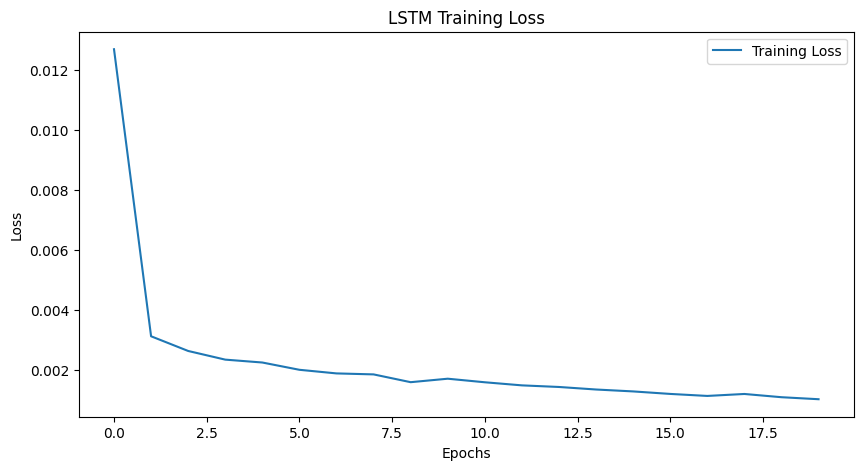

In [115]:

model.compile(optimizer=optimizer, loss='mean_squared_error')


history = model.fit(
    X_train, y_train,
    epochs=20,  # Reduce total epochs
    batch_size=64,  # Balanced batch size
    verbose=1  # Show progress
)

model.save("btcpricetest_model2.keras")
print("Model saved as 'btc_model.keras'")

# Plot training loss vs validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training Loss")
plt.legend()
plt.show()

In [116]:
from tensorflow.keras.models import Sequential, load_model


In [117]:
model = load_model("btcpricetest_model2.keras")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


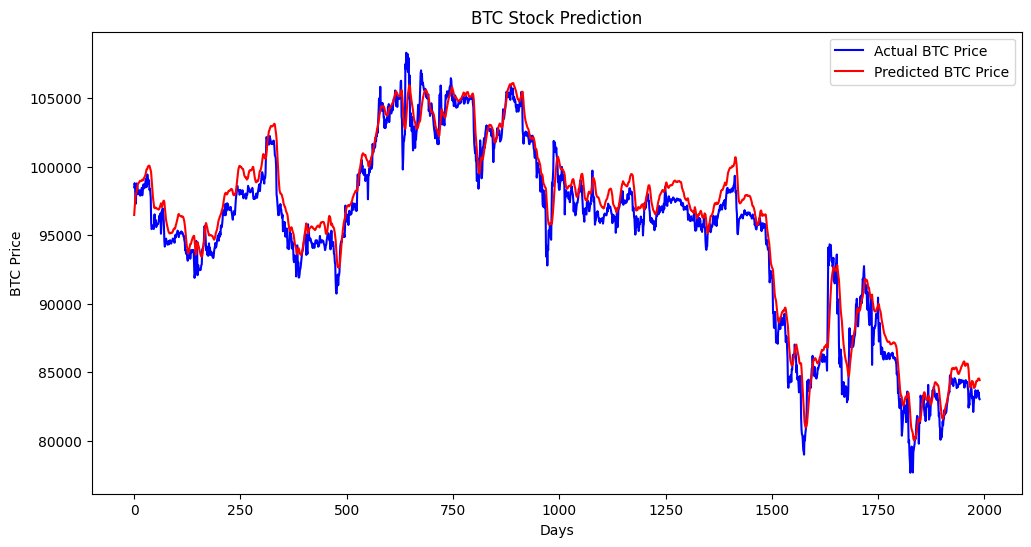

In [118]:
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1))
actual_prices = scaler_y.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(actual_prices, color="blue", label="Actual BTC Price")
plt.plot(predictions, color="red", label="Predicted BTC Price")
plt.title("BTC Stock Prediction")
plt.xlabel("Days")
plt.ylabel("BTC Price")
plt.legend()
plt.show()

In [119]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.5978e-04
Test Loss: 0.0004


In [120]:
history

In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predictions)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((actual_prices - predictions) / actual_prices)) * 100  # In percentage

# Print results as percentages
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-Squared (R²): {r2 * 100:.2f}%")

Mean Squared Error (MSE): 1888694.76
Mean Absolute Error (MAE): 1097.23
Mean Absolute Percentage Error (MAPE): 1.17%
R-Squared (R²): 95.75%


In [122]:
def predict_next_hour():
    # Fetch latest 20 hours of data
    live_df = fetch_ohlcv("BTC/USDT", "binance", "1h", max_bars=20 + 49)
    if live_df is None or len(live_df) < 20:
        print("Not enough data to make a prediction.")
        return None

    print(live_df.shape)

    # Keep only the required feature columns
    live_df = live_df[feature_columns]

    # Scale the data
    live_df_scaled = scaler_X.transform(live_df)

    # Reshape for model input (1 sample, 20 timesteps, feature count)
    input_seq = live_df_scaled.reshape(1, 20, len(feature_columns))

    # Predict next hour price
    pred_scaled = model.predict(input_seq)
    
    # Convert back to actual price
    pred_actual = scaler_y.inverse_transform(pred_scaled)

    # Return the predicted BTC price
    predicted_price = pred_actual[0][0]
    print(f"📈 Predicted BTC Price for Next Hour: ${predicted_price:.2f}")
    return predicted_price

In [123]:
predict_next_hour()

Fetched 69 bars, Total: 69
Last batch returned less than the limit. Likely at the end of data.
Final data count: 20 bars
(20, 13)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
📈 Predicted BTC Price for Next Hour: $83358.20


np.float32(83358.2)